# CREATING DATASET

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv

import glob
import time
import re

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [2]:
classes = glob.glob("dataset\\*")
image_paths = [glob.glob(class_+"\\*") for class_ in classes if len(glob.glob(class_+"\\*")) >= 300]
image_paths = np.array(np.hstack(image_paths), dtype="str")

In [3]:
image_paths.shape

(7701,)

In [4]:
# Reading images

start = time.process_time()
images = [cv.imread(path) for path in image_paths]
end = time.process_time()
print("Process took", end - start, "seconds to run.")

Process took 41.359375 seconds to run.


In [5]:
df = pd.DataFrame([], columns=["im", "class"])

In [6]:
df["im"] = [re.split(r'\\', path)[-1] for path in image_paths]

In [7]:
df["class"] = [re.split(r'\\', path)[1] for path in image_paths]
df["class"].value_counts()

kitchen           734
livingroom        705
bedroom           662
airport_inside    608
bar               603
subway            539
casino            515
restaurant        513
warehouse         506
inside_subway     457
bakery            405
pantry            384
bookstore         380
toystore          347
corridor          343
Name: class, dtype: int64

In [8]:
uniques = np.unique(df["class"])
NUM_CLASSES = len(uniques)

df.replace(to_replace = uniques, value = range(NUM_CLASSES), inplace=True)

df["class"].value_counts()

8     734
9     705
3     662
0     608
2     603
12    539
5     515
11    513
14    506
7     457
1     405
10    384
4     380
13    347
6     343
Name: class, dtype: int64

In [9]:
HEIGHT, WIDTH, CHANNELS = 100, 100, 3

def preprocess(im: np.ndarray) -> np.ndarray:
    im = cv.resize(im, (HEIGHT, WIDTH))
    im = im/255
    return im

In [10]:
# Processing images

start = time.process_time()
images_cnn = [preprocess(im) for im in images]
end = time.process_time()
print("Process took", end - start, "seconds to run.")

Process took 1.96875 seconds to run.


In [11]:
X = np.array(images_cnn)
y = np.array(to_categorical(df["class"], num_classes = NUM_CLASSES))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.50, random_state=42, stratify=y_test)

print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)
print("X test shape:", X_test.shape)
print("y test shape:", y_test.shape)
print("X validation shape:", X_validation.shape)
print("y validation shape:", y_validation.shape)

X train shape: (6160, 100, 100, 3)
y train shape: (6160, 15)
X test shape: (770, 100, 100, 3)
y test shape: (770, 15)
X validation shape: (771, 100, 100, 3)
y validation shape: (771, 15)


# TRAINING CNN

In [13]:
train_losses = []
train_accuracies = []

validation_losses = []
validation_accuracies = []

test_accuracies = []

conf_matrices = []
class_reports = []

In [14]:
EPOCH_SIZE = 100

In [15]:
start = time.process_time()
for BATCH_SIZE in [50, 100]:
    for LEARNING_RATE in [0.01, 0.001, 0.0001]:
        model = tf.keras.Sequential()

        model.add(layers.InputLayer(input_shape=(HEIGHT, WIDTH, CHANNELS)))

        model.add(layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(layers.MaxPool2D(pool_size=(2,2)))

        model.add(layers.Conv2D(8, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(layers.MaxPool2D(pool_size=(2,2)))

        model.add(layers.Flatten())
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

        history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_SIZE, validation_data = (X_validation, y_validation), shuffle=True)
        
        train_losses.append(history.history["loss"])
        train_accuracies.append(history.history["accuracy"])
        
        validation_losses.append(history.history["val_loss"])
        validation_accuracies.append(history.history["val_accuracy"])
        
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)
        
        test_accuracies.append(accuracy_score(y_test_classes, y_pred_classes))
        
        class_report = classification_report(y_test_classes, y_pred_classes)
        conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
        
        class_reports.append(class_report)
        conf_matrices.append(conf_matrix)
        
end = time.process_time()
print("Process took", end - start, "seconds to run.")

Epoch 1/100
124/124 [==============================] - 10s 72ms/step - loss: 2.7065 - accuracy: 0.0945 - val_loss: 2.6789 - val_accuracy: 0.0960
Epoch 2/100
124/124 [==============================] - 8s 68ms/step - loss: 2.6820 - accuracy: 0.0932 - val_loss: 2.6783 - val_accuracy: 0.0921s - loss: 2 - ETA: 0s - loss: 2.6822 - accuracy: 
Epoch 3/100
124/124 [==============================] - 8s 67ms/step - loss: 2.6819 - accuracy: 0.0953 - val_loss: 2.6781 - val_accuracy: 0.0960
Epoch 4/100
124/124 [==============================] - 7s 57ms/step - loss: 2.6817 - accuracy: 0.0935 - val_loss: 2.6788 - val_accuracy: 0.0960
Epoch 5/100
124/124 [==============================] - 9s 69ms/step - loss: 2.6816 - accuracy: 0.0930 - val_loss: 2.6781 - val_accuracy: 0.0960
Epoch 6/100
124/124 [==============================] - 10s 77ms/step - loss: 2.6819 - accuracy: 0.0933 - val_loss: 2.6778 - val_accuracy: 0.0960
Epoch 7/100
124/124 [==============================] - 10s 82ms/step - loss: 2.6811 -

C:\Users\palaz\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\palaz\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\palaz\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
124/124 [==============================] - 10s 71ms/step - loss: 2.6348 - accuracy: 0.1227 - val_loss: 2.4954 - val_accuracy: 0.1621
Epoch 2/100
124/124 [==============================] - 9s 72ms/step - loss: 2.4429 - accuracy: 0.1766 - val_loss: 2.4890 - val_accuracy: 0.1621 0s - loss: 2.4457 - 
Epoch 3/100
124/124 [==============================] - 9s 69ms/step - loss: 2.3062 - accuracy: 0.2263 - val_loss: 2.2857 - val_accuracy: 0.2283
Epoch 4/100
124/124 [==============================] - 8s 66ms/step - loss: 2.1373 - accuracy: 0.2779 - val_loss: 2.2180 - val_accuracy: 0.2503
Epoch 5/100
124/124 [==============================] - 9s 69ms/step - loss: 2.0249 - accuracy: 0.3097 - val_loss: 2.1210 - val_accuracy: 0.2789
Epoch 6/100
124/124 [==============================] - 8s 65ms/step - loss: 1.8829 - accuracy: 0.3539 - val_loss: 2.0978 - val_accuracy: 0.2879
Epoch 7/100
124/124 [==============================] - 8s 68ms/step - loss: 1.7995 - accuracy: 0.3841 - val_loss: 

124/124 [==============================] - 8s 66ms/step - loss: 0.0421 - accuracy: 0.9945 - val_loss: 9.1634 - val_accuracy: 0.2789
Epoch 58/100
124/124 [==============================] - 8s 66ms/step - loss: 0.0432 - accuracy: 0.9933 - val_loss: 9.1804 - val_accuracy: 0.2776
Epoch 59/100
124/124 [==============================] - 9s 71ms/step - loss: 0.0395 - accuracy: 0.9942 - val_loss: 9.3853 - val_accuracy: 0.2685
Epoch 60/100
124/124 [==============================] - 9s 69ms/step - loss: 0.0378 - accuracy: 0.9945 - val_loss: 9.5141 - val_accuracy: 0.2763
Epoch 61/100
124/124 [==============================] - 8s 67ms/step - loss: 0.1286 - accuracy: 0.9597 - val_loss: 9.3455 - val_accuracy: 0.2724
Epoch 62/100
124/124 [==============================] - 8s 66ms/step - loss: 0.3113 - accuracy: 0.8997 - val_loss: 9.0149 - val_accuracy: 0.2425
Epoch 63/100
124/124 [==============================] - 8s 66ms/step - loss: 0.2373 - accuracy: 0.9206 - val_loss: 9.0636 - val_accuracy: 0.268

Epoch 13/100
124/124 [==============================] - 8s 66ms/step - loss: 1.9371 - accuracy: 0.3599 - val_loss: 2.0468 - val_accuracy: 0.2853
Epoch 14/100
124/124 [==============================] - 8s 68ms/step - loss: 1.9187 - accuracy: 0.3630 - val_loss: 2.0455 - val_accuracy: 0.3087
Epoch 15/100
124/124 [==============================] - 8s 66ms/step - loss: 1.8972 - accuracy: 0.3740 - val_loss: 2.0408 - val_accuracy: 0.3100
Epoch 16/100
124/124 [==============================] - 8s 66ms/step - loss: 1.8740 - accuracy: 0.3833 - val_loss: 2.0172 - val_accuracy: 0.3048
Epoch 17/100
124/124 [==============================] - 8s 64ms/step - loss: 1.8547 - accuracy: 0.3943 - val_loss: 2.0083 - val_accuracy: 0.3191
Epoch 18/100
124/124 [==============================] - 8s 67ms/step - loss: 1.8388 - accuracy: 0.4063 - val_loss: 2.0107 - val_accuracy: 0.3230
Epoch 19/100
124/124 [==============================] - 8s 68ms/step - loss: 1.8173 - accuracy: 0.4062 - val_loss: 1.9932 - val_ac

Epoch 69/100
124/124 [==============================] - 9s 69ms/step - loss: 1.0780 - accuracy: 0.6786 - val_loss: 2.0933 - val_accuracy: 0.3333
Epoch 70/100
124/124 [==============================] - 10s 79ms/step - loss: 1.0640 - accuracy: 0.6781 - val_loss: 2.0687 - val_accuracy: 0.3502
Epoch 71/100
124/124 [==============================] - 9s 69ms/step - loss: 1.0522 - accuracy: 0.6865 - val_loss: 2.0694 - val_accuracy: 0.3463
Epoch 72/100
124/124 [==============================] - 9s 70ms/step - loss: 1.0438 - accuracy: 0.6894 - val_loss: 2.1173 - val_accuracy: 0.3463
Epoch 73/100
124/124 [==============================] - 8s 64ms/step - loss: 1.0237 - accuracy: 0.6916 - val_loss: 2.1054 - val_accuracy: 0.3567
Epoch 74/100
124/124 [==============================] - 8s 68ms/step - loss: 1.0122 - accuracy: 0.7037 - val_loss: 2.1096 - val_accuracy: 0.3398
Epoch 75/100
124/124 [==============================] - 8s 65ms/step - loss: 1.0082 - accuracy: 0.7011 - val_loss: 2.1799 - val_a

62/62 [==============================] - 6s 91ms/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 29.2897 - val_accuracy: 0.1530
Epoch 81/100
62/62 [==============================] - 6s 90ms/step - loss: 0.0102 - accuracy: 0.9976 - val_loss: 29.4724 - val_accuracy: 0.1466
Epoch 82/100
62/62 [==============================] - 6s 93ms/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 29.8254 - val_accuracy: 0.1453
Epoch 83/100
62/62 [==============================] - 6s 95ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 29.6989 - val_accuracy: 0.1505
Epoch 84/100
62/62 [==============================] - 6s 96ms/step - loss: 0.0090 - accuracy: 0.9979 - val_loss: 30.5547 - val_accuracy: 0.1556
Epoch 85/100
62/62 [==============================] - 6s 97ms/step - loss: 0.0101 - accuracy: 0.9971 - val_loss: 30.1369 - val_accuracy: 0.1505
Epoch 86/100
62/62 [==============================] - 6s 97ms/step - loss: 0.0101 - accuracy: 0.9971 - val_loss: 29.8882 - val_accuracy: 0.1595
Epoch

62/62 [==============================] - 6s 98ms/step - loss: 0.1121 - accuracy: 0.9685 - val_loss: 9.6372 - val_accuracy: 0.2477
Epoch 94/100
62/62 [==============================] - 6s 93ms/step - loss: 0.1342 - accuracy: 0.9604 - val_loss: 9.3242 - val_accuracy: 0.2464
Epoch 95/100
62/62 [==============================] - 6s 100ms/step - loss: 0.0702 - accuracy: 0.9852 - val_loss: 9.4708 - val_accuracy: 0.2425
Epoch 96/100
62/62 [==============================] - 6s 102ms/step - loss: 0.0451 - accuracy: 0.9933 - val_loss: 9.5937 - val_accuracy: 0.2464
Epoch 97/100
62/62 [==============================] - 6s 97ms/step - loss: 0.0340 - accuracy: 0.9940 - val_loss: 9.7705 - val_accuracy: 0.2464
Epoch 98/100
62/62 [==============================] - 6s 98ms/step - loss: 0.0315 - accuracy: 0.9950 - val_loss: 9.9198 - val_accuracy: 0.2374
Epoch 99/100
62/62 [==============================] - 6s 96ms/step - loss: 0.0306 - accuracy: 0.9945 - val_loss: 9.9231 - val_accuracy: 0.2490
Epoch 100/

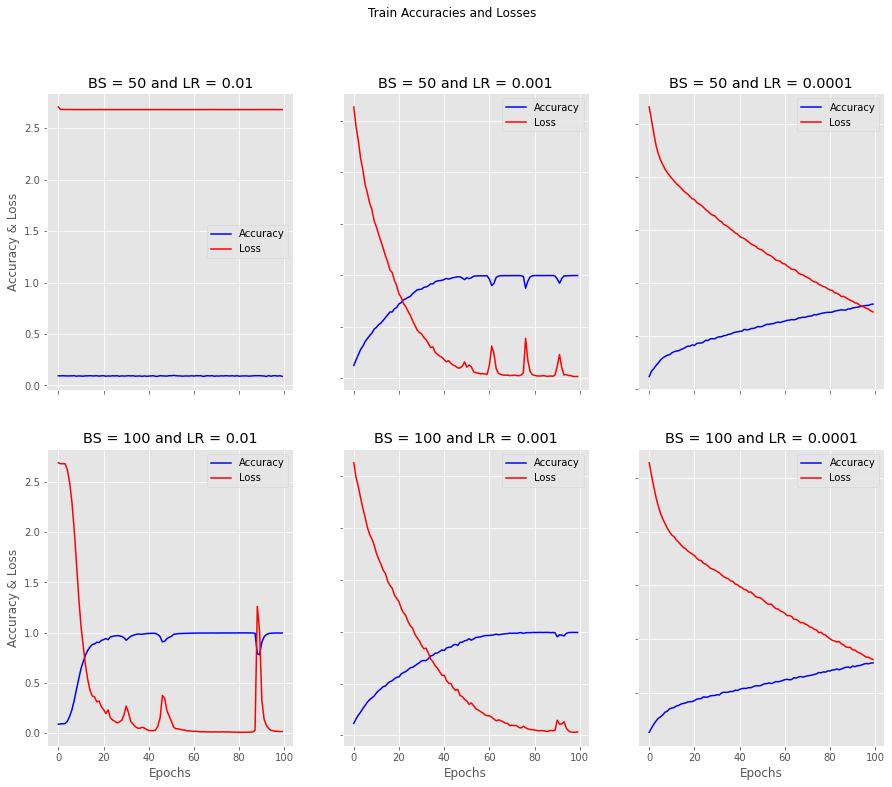

In [34]:
figure, axis = plt.subplots(2, 3, figsize=(15, 12))
figure.suptitle("Train Accuracies and Losses")

axis[0,0].plot(train_accuracies[0], color='b', label="Accuracy")
axis[0,0].plot(train_losses[0], color='r', label="Loss")
axis[0,0].set_title("BS = 50 and LR = 0.01")
axis[0,0].legend()

axis[0,1].plot(train_accuracies[1], color='b', label="Accuracy")
axis[0,1].plot(train_losses[1], color='r', label="Loss")
axis[0,1].set_title("BS = 50 and LR = 0.001")
axis[0,1].legend()

axis[0,2].plot(train_accuracies[2], color='b', label="Accuracy")
axis[0,2].plot(train_losses[2], color='r', label="Loss")
axis[0,2].set_title("BS = 50 and LR = 0.0001")
axis[0,2].legend()

axis[1,0].plot(train_accuracies[3], color='b', label="Accuracy")
axis[1,0].plot(train_losses[3], color='r', label="Loss")
axis[1,0].set_title("BS = 100 and LR = 0.01")
axis[1,0].legend()

axis[1,1].plot(train_accuracies[4], color='b', label="Accuracy")
axis[1,1].plot(train_losses[4], color='r', label="Loss")
axis[1,1].set_title("BS = 100 and LR = 0.001")
axis[1,1].legend()

axis[1,2].plot(train_accuracies[5], color='b', label="Accuracy")
axis[1,2].plot(train_losses[5], color='r', label="Loss")
axis[1,2].set_title("BS = 100 and LR = 0.0001")
axis[1,2].legend()

for ax in axis.flat:
    ax.set(xlabel='Epochs', ylabel='Accuracy & Loss')
for ax in axis.flat:
    ax.label_outer()

plt.savefig('train_acc.png', bbox_inches='tight')
plt.show()

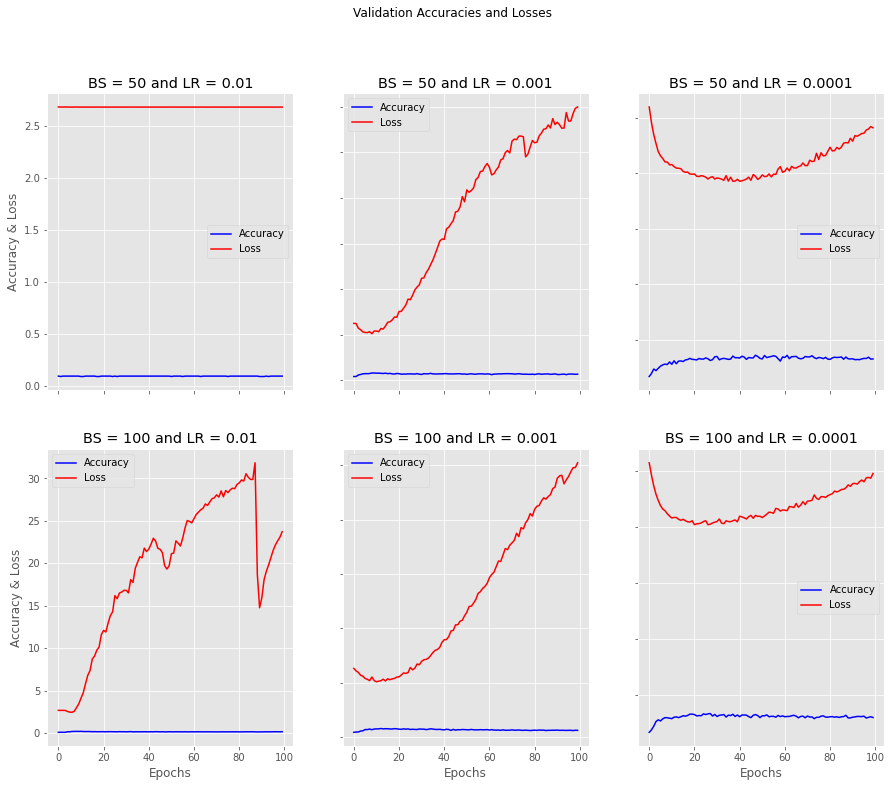

In [33]:
figure, axis = plt.subplots(2, 3, figsize=(15, 12))
figure.suptitle("Validation Accuracies and Losses")

axis[0,0].plot(validation_accuracies[0], color='b', label="Accuracy")
axis[0,0].plot(validation_losses[0], color='r', label="Loss")
axis[0,0].set_title("BS = 50 and LR = 0.01")
axis[0,0].legend()

axis[0,1].plot(validation_accuracies[1], color='b', label="Accuracy")
axis[0,1].plot(validation_losses[1], color='r', label="Loss")
axis[0,1].set_title("BS = 50 and LR = 0.001")
axis[0,1].legend()

axis[0,2].plot(validation_accuracies[2], color='b', label="Accuracy")
axis[0,2].plot(validation_losses[2], color='r', label="Loss")
axis[0,2].set_title("BS = 50 and LR = 0.0001")
axis[0,2].legend()

axis[1,0].plot(validation_accuracies[3], color='b', label="Accuracy")
axis[1,0].plot(validation_losses[3], color='r', label="Loss")
axis[1,0].set_title("BS = 100 and LR = 0.01")
axis[1,0].legend()

axis[1,1].plot(validation_accuracies[4], color='b', label="Accuracy")
axis[1,1].plot(validation_losses[4], color='r', label="Loss")
axis[1,1].set_title("BS = 100 and LR = 0.001")
axis[1,1].legend()

axis[1,2].plot(validation_accuracies[5], color='b', label="Accuracy")
axis[1,2].plot(validation_losses[5], color='r', label="Loss")
axis[1,2].set_title("BS = 100 and LR = 0.0001")
axis[1,2].legend()

for ax in axis.flat:
    ax.set(xlabel='Epochs', ylabel='Accuracy & Loss')
for ax in axis.flat:
    ax.label_outer()

plt.savefig('val_acc.png', bbox_inches='tight')
plt.show()

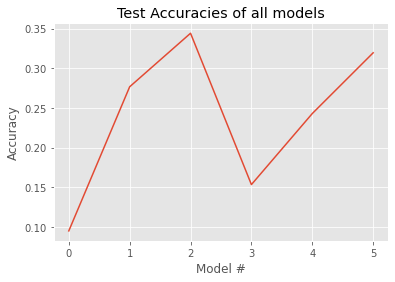

In [32]:
plt.figure()

plt.plot(test_accuracies)
plt.title("Test Accuracies of all models")
plt.xlabel("Model #")
plt.ylabel("Accuracy")

plt.savefig('test_acc.png', bbox_inches='tight')
plt.show()

## Model with no dropouts

In [19]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 8)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                160032    
_________________________________________________________________
dense_11 (Dense)             (None, 15)               

In [44]:
len(conf_matrices)

6

### Confusion Matricies

In [45]:
batch_sizes = [50, 100]
learning_rates = [0.01, 0.001, 0.0001]
for i in range(len(conf_matrices)):
    print("Confusion matrix of model", i, "with batch size of", batch_sizes[i//3], "and learning rate of", learning_rates[max(i, i-3) - 3])
    print()
    print(conf_matrices[i])
    print()
    print()

Confusion matrix of model 0 with batch size of 50 and learning rate of 0.01

[[ 0  0  0  0  0  0  0  0 61  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 41  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 60  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 66  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 38  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 51  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 46  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 73  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 70  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 39  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 51  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 54  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  0  0]]


Confusion matrix of model 1 with batch size of 50 and learning rate of 0.001

[[17  3  6  0  1  0  0  8  2  3  3  0 11  1  6]
 [ 2  6  0  2  5  2  0  0  4  6  5  2  3  1  3]
 [ 1  4 19  0  3  8  1  0 

In [22]:
dropout_train_accuracies = []
dropout_train_losses = []

dropout_validation_accuracies = []
dropout_validation_losses = []

dropout_test_accuracies = []

dropout_conf_matrices = []
dropout_class_reports = []

In [24]:
start = time.process_time()
for DROPOUT in [0.1, 0.25, 0.5, 0.75]:
    model_ = tf.keras.Sequential()

    model_.add(layers.InputLayer(input_shape=(HEIGHT, WIDTH, CHANNELS)))

    model_.add(layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
    model_.add(layers.MaxPool2D(pool_size=(2,2)))
    model_.add(layers.Dropout(DROPOUT))

    model_.add(layers.Conv2D(8, kernel_size=(3,3), padding='same', activation='relu'))
    model_.add(layers.MaxPool2D(pool_size=(2,2)))
    model_.add(layers.Dropout(DROPOUT))

    model_.add(layers.Flatten())
    model_.add(layers.Dense(32, activation='relu'))
    model_.add(layers.Dropout(DROPOUT))
    model_.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    model_.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

    history_ = model_.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_SIZE, validation_data = (X_validation, y_validation), shuffle=True)
    
    dropout_train_losses.append(history_.history["loss"])
    dropout_train_accuracies.append(history_.history["accuracy"])

    dropout_validation_losses.append(history_.history["val_loss"])
    dropout_validation_accuracies.append(history_.history["val_accuracy"])

    y_pred_ = model.predict(X_test)
    y_pred_classes_ = np.argmax(y_pred_, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    dropout_test_accuracies.append(accuracy_score(y_test_classes, y_pred_classes_))
    
    class_report = classification_report(y_test_classes, y_pred_classes_)
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes_)

    dropout_class_reports.append(class_report)
    dropout_conf_matrices.append(conf_matrix)
end = time.process_time()
print("Process took", end - start, "seconds to run.")

Epoch 1/100
62/62 [==============================] - 8s 127ms/step - loss: 2.6946 - accuracy: 0.0856 - val_loss: 2.6548 - val_accuracy: 0.1038
Epoch 2/100
62/62 [==============================] - 9s 139ms/step - loss: 2.6081 - accuracy: 0.1339 - val_loss: 2.5805 - val_accuracy: 0.1440
Epoch 3/100
62/62 [==============================] - 9s 152ms/step - loss: 2.5353 - accuracy: 0.1586 - val_loss: 2.4877 - val_accuracy: 0.1894
Epoch 4/100
62/62 [==============================] - 8s 127ms/step - loss: 2.4695 - accuracy: 0.1802 - val_loss: 2.4093 - val_accuracy: 0.1881
Epoch 5/100
62/62 [==============================] - 8s 131ms/step - loss: 2.4171 - accuracy: 0.1933 - val_loss: 2.3546 - val_accuracy: 0.2088
Epoch 6/100
62/62 [==============================] - 8s 129ms/step - loss: 2.3670 - accuracy: 0.2101 - val_loss: 2.3265 - val_accuracy: 0.2438
Epoch 7/100
62/62 [==============================] - 8s 129ms/step - loss: 2.3346 - accuracy: 0.2292 - val_loss: 2.2873 - val_accuracy: 0.2412

Epoch 58/100
62/62 [==============================] - 8s 132ms/step - loss: 1.6136 - accuracy: 0.4721 - val_loss: 1.9198 - val_accuracy: 0.3346
Epoch 59/100
62/62 [==============================] - 8s 130ms/step - loss: 1.6017 - accuracy: 0.4784 - val_loss: 1.9421 - val_accuracy: 0.3411
Epoch 60/100
62/62 [==============================] - 8s 126ms/step - loss: 1.5874 - accuracy: 0.4744 - val_loss: 1.9168 - val_accuracy: 0.3385
Epoch 61/100
62/62 [==============================] - 8s 131ms/step - loss: 1.5813 - accuracy: 0.4830 - val_loss: 1.9142 - val_accuracy: 0.3463
Epoch 62/100
62/62 [==============================] - 8s 133ms/step - loss: 1.5743 - accuracy: 0.4914 - val_loss: 1.9251 - val_accuracy: 0.3411
Epoch 63/100
62/62 [==============================] - 8s 124ms/step - loss: 1.5545 - accuracy: 0.4903 - val_loss: 1.9218 - val_accuracy: 0.3359
Epoch 64/100
62/62 [==============================] - 8s 128ms/step - loss: 1.5554 - accuracy: 0.4901 - val_loss: 1.9172 - val_accuracy:

Epoch 71/100
62/62 [==============================] - 8s 124ms/step - loss: 1.6852 - accuracy: 0.4445 - val_loss: 1.9025 - val_accuracy: 0.3696
Epoch 72/100
62/62 [==============================] - 8s 126ms/step - loss: 1.6844 - accuracy: 0.4409 - val_loss: 1.9015 - val_accuracy: 0.3528
Epoch 73/100
62/62 [==============================] - 8s 130ms/step - loss: 1.6874 - accuracy: 0.4406 - val_loss: 1.8967 - val_accuracy: 0.3554
Epoch 74/100
62/62 [==============================] - 8s 128ms/step - loss: 1.6751 - accuracy: 0.4412 - val_loss: 1.8957 - val_accuracy: 0.3502
Epoch 75/100
62/62 [==============================] - 8s 129ms/step - loss: 1.6741 - accuracy: 0.4427 - val_loss: 1.8930 - val_accuracy: 0.3709
Epoch 76/100
62/62 [==============================] - 8s 131ms/step - loss: 1.6553 - accuracy: 0.4438 - val_loss: 1.8890 - val_accuracy: 0.3632
Epoch 77/100
62/62 [==============================] - 8s 126ms/step - loss: 1.6528 - accuracy: 0.4495 - val_loss: 1.8964 - val_accuracy:

Epoch 28/100
62/62 [==============================] - 8s 126ms/step - loss: 2.4049 - accuracy: 0.1976 - val_loss: 2.3735 - val_accuracy: 0.2374
Epoch 29/100
62/62 [==============================] - 8s 132ms/step - loss: 2.3966 - accuracy: 0.1891 - val_loss: 2.3772 - val_accuracy: 0.2399
Epoch 30/100
62/62 [==============================] - 8s 133ms/step - loss: 2.4022 - accuracy: 0.1903 - val_loss: 2.3584 - val_accuracy: 0.2477
Epoch 31/100
62/62 [==============================] - 8s 133ms/step - loss: 2.3732 - accuracy: 0.1995 - val_loss: 2.3416 - val_accuracy: 0.2542
Epoch 32/100
62/62 [==============================] - 8s 136ms/step - loss: 2.3876 - accuracy: 0.2011 - val_loss: 2.3416 - val_accuracy: 0.2529
Epoch 33/100
62/62 [==============================] - 8s 125ms/step - loss: 2.3760 - accuracy: 0.1987 - val_loss: 2.3214 - val_accuracy: 0.2646
Epoch 34/100
62/62 [==============================] - 8s 132ms/step - loss: 2.3674 - accuracy: 0.1950 - val_loss: 2.3203 - val_accuracy:

Epoch 85/100
62/62 [==============================] - 8s 128ms/step - loss: 2.1389 - accuracy: 0.2680 - val_loss: 2.0916 - val_accuracy: 0.3165
Epoch 86/100
62/62 [==============================] - 8s 133ms/step - loss: 2.1322 - accuracy: 0.2695 - val_loss: 2.0965 - val_accuracy: 0.3165
Epoch 87/100
62/62 [==============================] - 9s 138ms/step - loss: 2.1349 - accuracy: 0.2620 - val_loss: 2.0889 - val_accuracy: 0.3165
Epoch 88/100
62/62 [==============================] - 8s 123ms/step - loss: 2.1389 - accuracy: 0.2656 - val_loss: 2.1052 - val_accuracy: 0.3191
Epoch 89/100
62/62 [==============================] - 7s 119ms/step - loss: 2.1295 - accuracy: 0.2669 - val_loss: 2.0931 - val_accuracy: 0.3165
Epoch 90/100
62/62 [==============================] - 7s 114ms/step - loss: 2.1323 - accuracy: 0.2708 - val_loss: 2.0911 - val_accuracy: 0.3243
Epoch 91/100
62/62 [==============================] - 7s 110ms/step - loss: 2.1325 - accuracy: 0.2739 - val_loss: 2.0741 - val_accuracy:

Epoch 42/100
62/62 [==============================] - 8s 125ms/step - loss: 2.6887 - accuracy: 0.0956 - val_loss: 2.6877 - val_accuracy: 0.0960
Epoch 43/100
62/62 [==============================] - 8s 126ms/step - loss: 2.6885 - accuracy: 0.0953 - val_loss: 2.6874 - val_accuracy: 0.0960
Epoch 44/100
62/62 [==============================] - 8s 124ms/step - loss: 2.6881 - accuracy: 0.0951 - val_loss: 2.6871 - val_accuracy: 0.0960
Epoch 45/100
62/62 [==============================] - 8s 129ms/step - loss: 2.6875 - accuracy: 0.0951 - val_loss: 2.6869 - val_accuracy: 0.0960
Epoch 46/100
62/62 [==============================] - 8s 130ms/step - loss: 2.6879 - accuracy: 0.0948 - val_loss: 2.6866 - val_accuracy: 0.0960
Epoch 47/100
62/62 [==============================] - 8s 124ms/step - loss: 2.6873 - accuracy: 0.0956 - val_loss: 2.6864 - val_accuracy: 0.0960
Epoch 48/100
62/62 [==============================] - 8s 127ms/step - loss: 2.6870 - accuracy: 0.0953 - val_loss: 2.6861 - val_accuracy:

Epoch 99/100
62/62 [==============================] - 8s 129ms/step - loss: 2.6806 - accuracy: 0.0953 - val_loss: 2.6794 - val_accuracy: 0.0960
Epoch 100/100
62/62 [==============================] - 8s 126ms/step - loss: 2.6805 - accuracy: 0.0953 - val_loss: 2.6794 - val_accuracy: 0.0960
Process took 33162.03125 seconds to run.


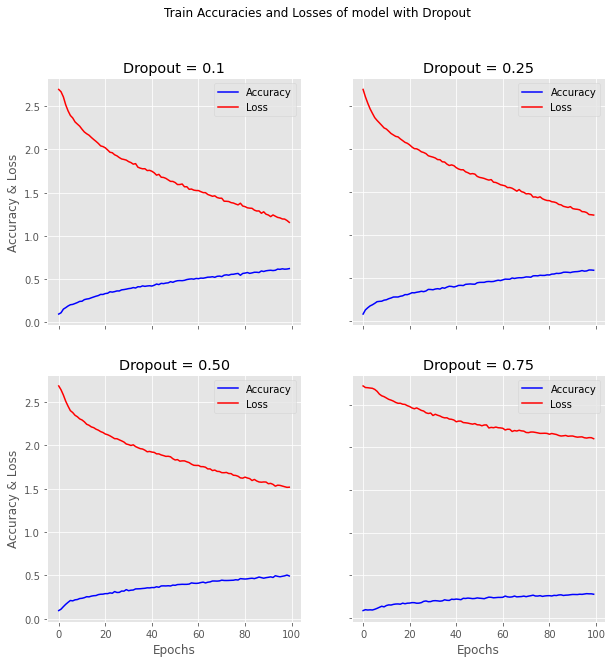

In [31]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10))
figure.suptitle("Train Accuracies and Losses of model with Dropout")

axis[0,0].plot(dropout_train_accuracies[0], color='b', label="Accuracy")
axis[0,0].plot(dropout_train_losses[0], color='r', label="Loss")
axis[0,0].set_title("Dropout = 0.1")
axis[0,0].legend()

axis[0,1].plot(dropout_train_accuracies[1], color='b', label="Accuracy")
axis[0,1].plot(dropout_train_losses[1], color='r', label="Loss")
axis[0,1].set_title("Dropout = 0.25")
axis[0,1].legend()

axis[1,0].plot(dropout_train_accuracies[2], color='b', label="Accuracy")
axis[1,0].plot(dropout_train_losses[2], color='r', label="Loss")
axis[1,0].set_title("Dropout = 0.50")
axis[1,0].legend()

axis[1,1].plot(dropout_train_accuracies[3], color='b', label="Accuracy")
axis[1,1].plot(dropout_train_losses[3], color='r', label="Loss")
axis[1,1].set_title("Dropout = 0.75")
axis[1,1].legend()

for ax in axis.flat:
    ax.set(xlabel='Epochs', ylabel='Accuracy & Loss')
for ax in axis.flat:
    ax.label_outer()

plt.savefig('train_acc_dropout.png', bbox_inches='tight')
plt.show()

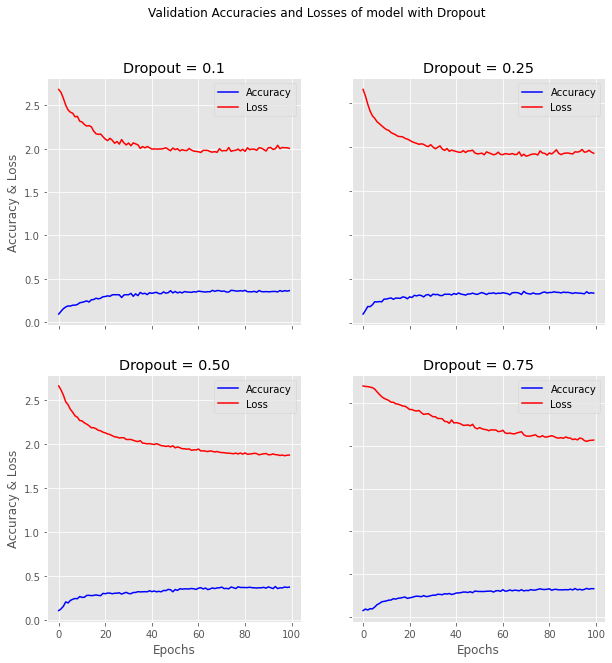

In [30]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10))
figure.suptitle("Validation Accuracies and Losses of model with Dropout")

axis[0,0].plot(dropout_validation_accuracies[0], color='b', label="Accuracy")
axis[0,0].plot(dropout_validation_losses[0], color='r', label="Loss")
axis[0,0].set_title("Dropout = 0.1")
axis[0,0].legend()

axis[0,1].plot(dropout_validation_accuracies[1], color='b', label="Accuracy")
axis[0,1].plot(dropout_validation_losses[1], color='r', label="Loss")
axis[0,1].set_title("Dropout = 0.25")
axis[0,1].legend()

axis[1,0].plot(dropout_validation_accuracies[2], color='b', label="Accuracy")
axis[1,0].plot(dropout_validation_losses[2], color='r', label="Loss")
axis[1,0].set_title("Dropout = 0.50")
axis[1,0].legend()

axis[1,1].plot(dropout_validation_accuracies[3], color='b', label="Accuracy")
axis[1,1].plot(dropout_validation_losses[3], color='r', label="Loss")
axis[1,1].set_title("Dropout = 0.75")
axis[1,1].legend()

for ax in axis.flat:
    ax.set(xlabel='Epochs', ylabel='Accuracy & Loss')
for ax in axis.flat:
    ax.label_outer()

plt.savefig('val_acc_dropout.png', bbox_inches='tight')
plt.show()

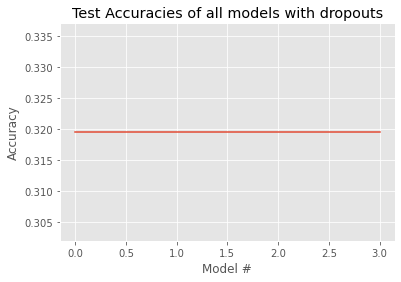

In [29]:
plt.figure()

plt.plot(dropout_test_accuracies)
plt.title("Test Accuracies of all models with dropouts")
plt.xlabel("Model #")
plt.ylabel("Accuracy")

plt.savefig('test_acc_dropout.png', bbox_inches='tight')
plt.show()

## Model with dropouts

In [37]:
model_.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 25, 25, 8)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 25, 25, 8)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 5000)            

In [46]:
dropouts = [0.1, 0.25, 0.5, 0.75]
for i in range(len(dropout_conf_matrices)):
    print("Confusion matrix of model", i, "with dropout of", dropouts[i])
    print()
    print(dropout_conf_matrices[i])
    print()
    print()

Confusion matrix of model 0 with dropout of 0.1

[[24  0  3  2  3  2  1  4  3  2  1  1  6  4  5]
 [ 1  4  2  4  7  1  1  0  6  3  1  5  3  1  2]
 [ 1  1 12  0  5  9  2  1  5  6  1 12  3  2  0]
 [ 0  0  1 38  0  0  2  0  8  7  1  5  0  1  3]
 [ 1  2  2  1  9  4  0  1  2  1  1  7  1  2  4]
 [ 5  1  7  1  3 21  0  3  0  1  0  3  5  0  1]
 [ 1  0  1  3  0  0 22  0  2  1  1  1  1  0  2]
 [ 2  1  1  2  2  3  2 16  1  2  1  3  6  0  4]
 [ 1  1  1 17  0  1  6  1 23  9  0  5  4  1  3]
 [ 0  1  3 27  1  1  2  2 12 15  0  1  1  0  4]
 [ 2  2  2  1  1  1  2  0  8  1  9  3  2  1  4]
 [ 2  1  2  8  6 10  0  1  2  2  0 12  1  0  4]
 [ 4  1  0  3  5  3  1  2  3  2  1  4 16  1  8]
 [ 3  2  1  1  8  4  0  2  0  2  2  4  0  3  3]
 [ 5  0  0  4  2  4  1  1  3  2  2  1  3  0 22]]


Confusion matrix of model 1 with dropout of 0.25

[[24  0  3  2  3  2  1  4  3  2  1  1  6  4  5]
 [ 1  4  2  4  7  1  1  0  6  3  1  5  3  1  2]
 [ 1  1 12  0  5  9  2  1  5  6  1 12  3  2  0]
 [ 0  0  1 38  0  0  2  0  8  7  1

# TRAINING VGG

In [10]:
#Preprocessing images for VGG

start = time.process_time()
images_vgg = np.array([preprocess(im) for im in images])
images_vgg = preprocess_input(images_vgg) #required for vgg16
end = time.process_time()
print("Process took", end - start, "seconds to run.")

Process took 3.796875 seconds to run.


In [11]:
X = np.array(images_vgg)
y = np.array(to_categorical(df["class"], num_classes = NUM_CLASSES))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.50, random_state=42, stratify=y_test)

print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)
print("X test shape:", X_test.shape)
print("y test shape:", y_test.shape)
print("X validation shape:", X_validation.shape)
print("y validation shape:", y_validation.shape)

X train shape: (6160, 100, 100, 3)
y train shape: (6160, 15)
X test shape: (770, 100, 100, 3)
y test shape: (770, 15)
X validation shape: (771, 100, 100, 3)
y validation shape: (771, 15)


In [12]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape = (HEIGHT, WIDTH, CHANNELS))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [13]:
for layer in vgg.layers:
    layer.trainable = False

## VGG16 Only Dense Layers Trained

In [20]:
model_vgg = tf.keras.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                294976    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 15)                495       
Total params: 15,012,239
Trainable params: 297,551
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
model_vgg.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

history_vgg = model_vgg.fit(X_train, y_train, batch_size=100, epochs=100, validation_data = (X_validation, y_validation), shuffle=True)

Epoch 1/100
62/62 [==============================] - 162s 3s/step - loss: 2.8302 - accuracy: 0.0813 - val_loss: 2.6737 - val_accuracy: 0.0973
Epoch 2/100
62/62 [==============================] - 161s 3s/step - loss: 2.6711 - accuracy: 0.1026 - val_loss: 2.6587 - val_accuracy: 0.1064
Epoch 3/100
62/62 [==============================] - 166s 3s/step - loss: 2.6685 - accuracy: 0.1006 - val_loss: 2.6495 - val_accuracy: 0.1064
Epoch 4/100
62/62 [==============================] - 171s 3s/step - loss: 2.6348 - accuracy: 0.1097 - val_loss: 2.6266 - val_accuracy: 0.1141
Epoch 5/100
62/62 [==============================] - 168s 3s/step - loss: 2.6072 - accuracy: 0.1206 - val_loss: 2.5824 - val_accuracy: 0.1336
Epoch 6/100
62/62 [==============================] - 170s 3s/step - loss: 2.6026 - accuracy: 0.1224 - val_loss: 2.5587 - val_accuracy: 0.1206
Epoch 7/100
62/62 [==============================] - 174s 3s/step - loss: 2.5691 - accuracy: 0.1336 - val_loss: 2.5956 - val_accuracy: 0.1102
Epoch 

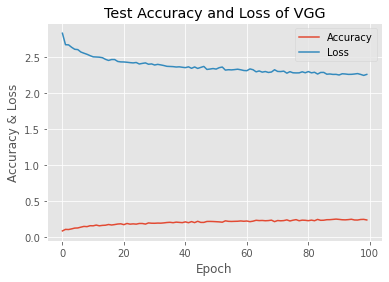

In [24]:
plt.figure()

plt.plot(history_vgg.history["accuracy"], label="Accuracy")
plt.plot(history_vgg.history["loss"], label="Loss")

plt.title("Train Accuracy and Loss of VGG")
plt.xlabel("Epoch")
plt.ylabel("Accuracy & Loss")
plt.legend()

plt.savefig('train_acc_vgg.png', bbox_inches='tight')
plt.show()

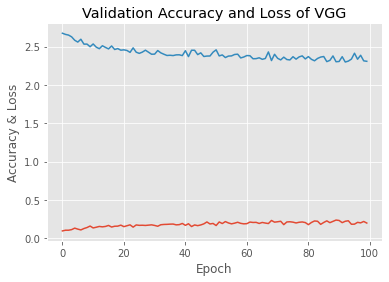

In [25]:
plt.figure()

plt.plot(history_vgg.history["val_accuracy"], label="Accuracy")
plt.plot(history_vgg.history["val_loss"], label="Loss")
plt.title("Validation Accuracy and Loss of VGG")
plt.xlabel("Epoch")
plt.ylabel("Accuracy & Loss")

plt.savefig('validation_acc_vgg.png', bbox_inches='tight')
plt.show()

In [26]:
y_pred_vgg = model_vgg.predict(X_test)
y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

vgg_accuracy_fc = accuracy_score(y_test_classes, y_pred_classes_vgg)

print("VGG that only Dense layers trained has accuracy of", vgg_accuracy_fc)

VGG that only Dense layers trained has accuracy of 0.22467532467532467


In [27]:
conf_matrix_vgg = confusion_matrix(y_test_classes, y_pred_classes_vgg)
print("Confusion matrix of VGG that only Dense layers trained")
print(conf_matrix_vgg)

Confusion matrix of VGG that only Dense layers trained
[[14  0  0  5  1  0  2  7  1  3  6  4  8  5  5]
 [ 7  4  0  1  2  0  0  1  1  3 12  2  0  6  2]
 [17  1  3  0  1  1  3  7  1  7  8  3  2  1  5]
 [ 2  0  0 34  0  0 10  1  1 13  1  1  2  0  1]
 [ 8  2  1  1  1  1  0  4  0  1 10  1  2  4  2]
 [14  0  1  2  0  0  0  7  0  3  8  6  2  4  4]
 [ 1  0  0  3  0  0 23  3  0  1  2  0  1  0  1]
 [ 5  0  0  0  0  1  3 21  0  0  5  3  2  0  6]
 [10  0  0 18  0  0  7  1  7 15  4  4  2  1  4]
 [ 5  1  1 18  0  1  3  4  5 15  4  5  3  0  5]
 [ 5  1  1  1  0  0  1  6  1  3 13  3  0  2  2]
 [ 9  0  0  5  0  1  0  3  1  8 13  9  1  0  1]
 [ 7  1  0  3  0  1  9  4  0  2  3  0 12  1 11]
 [ 6  3  0  1  2  1  0  2  0  1  8  0  0  6  5]
 [10  0  0  3  1  0  1  2  0  2 11  2  5  2 11]]


## VGG16 Dense Layers and Last Conv2D layer trainable

In [14]:
vgg.layers[-1].trainable = True
vgg.layers[-2].trainable = True
model_vgg_ = tf.keras.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])
model_vgg_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                294976    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                495       
Total params: 15,012,239
Trainable params: 2,657,359
Non-trainable params: 12,354,880
_________________________________________________________________


In [21]:
start = time.process_time()

model_vgg_.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
history_vgg_ = model_vgg_.fit(X_train, y_train, batch_size=100, epochs=100, validation_data = (X_validation, y_validation), shuffle=True)

end = time.process_time()
print("Process took", end - start, "seconds to run.")

Epoch 1/100
62/62 [==============================] - 200s 3s/step - loss: 2.7090 - accuracy: 0.0901 - val_loss: 2.6783 - val_accuracy: 0.1051
Epoch 2/100
62/62 [==============================] - 202s 3s/step - loss: 2.6799 - accuracy: 0.0955 - val_loss: 2.6571 - val_accuracy: 0.0973
Epoch 3/100
62/62 [==============================] - 189s 3s/step - loss: 2.6419 - accuracy: 0.1062 - val_loss: 2.6252 - val_accuracy: 0.1012
Epoch 4/100
62/62 [==============================] - 191s 3s/step - loss: 2.6048 - accuracy: 0.1235 - val_loss: 2.5805 - val_accuracy: 0.1427
Epoch 5/100
62/62 [==============================] - 181s 3s/step - loss: 2.5750 - accuracy: 0.1390 - val_loss: 2.5479 - val_accuracy: 0.1310
Epoch 6/100
62/62 [==============================] - 172s 3s/step - loss: 2.5618 - accuracy: 0.1344 - val_loss: 2.5385 - val_accuracy: 0.1530
Epoch 7/100
62/62 [==============================] - 173s 3s/step - loss: 2.5462 - accuracy: 0.1427 - val_loss: 2.5112 - val_accuracy: 0.1388
Epoch 

62/62 [==============================] - 188s 3s/step - loss: 2.1292 - accuracy: 0.2713 - val_loss: 2.3324 - val_accuracy: 0.2244
Epoch 59/100
62/62 [==============================] - 165s 3s/step - loss: 2.1391 - accuracy: 0.2739 - val_loss: 2.2266 - val_accuracy: 0.2425
Epoch 60/100
62/62 [==============================] - 167s 3s/step - loss: 2.1336 - accuracy: 0.2758 - val_loss: 2.2329 - val_accuracy: 0.2283
Epoch 61/100
62/62 [==============================] - 165s 3s/step - loss: 2.1324 - accuracy: 0.2719 - val_loss: 2.2337 - val_accuracy: 0.2451
Epoch 62/100
62/62 [==============================] - 165s 3s/step - loss: 2.1378 - accuracy: 0.2756 - val_loss: 2.2335 - val_accuracy: 0.2322
Epoch 63/100
62/62 [==============================] - 165s 3s/step - loss: 2.1145 - accuracy: 0.2804 - val_loss: 2.2171 - val_accuracy: 0.2361
Epoch 64/100
62/62 [==============================] - 164s 3s/step - loss: 2.1233 - accuracy: 0.2808 - val_loss: 2.2436 - val_accuracy: 0.2166
Epoch 65/100

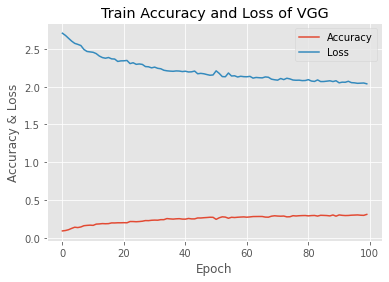

In [22]:
plt.figure()

plt.plot(history_vgg_.history["accuracy"], label="Accuracy")
plt.plot(history_vgg_.history["loss"], label="Loss")

plt.title("Train Accuracy and Loss of VGG")
plt.xlabel("Epoch")
plt.ylabel("Accuracy & Loss")
plt.legend()

plt.savefig('train_acc_vgg_conf2.png', bbox_inches='tight')
plt.show()

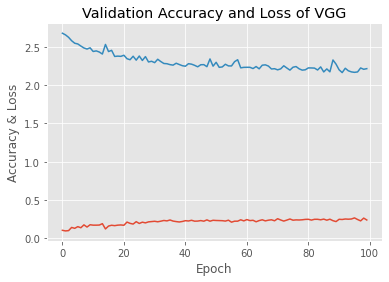

In [23]:
plt.figure()

plt.plot(history_vgg_.history["val_accuracy"], label="Accuracy")
plt.plot(history_vgg_.history["val_loss"], label="Loss")
plt.title("Validation Accuracy and Loss of VGG")
plt.xlabel("Epoch")
plt.ylabel("Accuracy & Loss")

plt.savefig('validation_acc_vgg_conf2.png', bbox_inches='tight')
plt.show()

In [25]:
y_pred_vgg_ = model_vgg_.predict(X_test)
y_pred_classes_vgg_ = np.argmax(y_pred_vgg_, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

vgg_accuracy_fc_conf2 = accuracy_score(y_test_classes, y_pred_classes_vgg_)

print("VGG that Dense layers & last Convolution layer trained has accuracy of", vgg_accuracy_fc_conf2)

VGG that Dense layers & last Convolution layer trained has accuracy of 0.24675324675324675


In [26]:
conf_matrix_vgg = confusion_matrix(y_test_classes, y_pred_classes_vgg_)
print("Confusion matrix of VGG that Dense layers & last Convolution layer trained")
print(conf_matrix_vgg)

Confusion matrix of VGG that Dense layers & last Convolution layer trained
[[ 0  0  2  6  4 10  0 14  2  1  0  7  8  2  5]
 [ 3  0  4  1  9  4  0  2  0  1  7  2  1  5  2]
 [ 2  0  2  0  8 17  3 11  2  1  2  6  2  2  2]
 [ 0  0  2 32  0  3 14  0  1  8  0  2  4  0  0]
 [ 0  0  2  0 11  8  0  6  0  0  2  4  2  3  0]
 [ 0  0  2  2  6 17  0 12  0  2  1  3  2  3  1]
 [ 1  0  0  5  0  1 21  3  0  0  0  1  3  0  0]
 [ 0  1  0  0  1  1  3 33  0  0  0  2  5  0  0]
 [ 1  0  6 22  1  2  7  4 10  8  1  9  0  0  2]
 [ 0  0  5 23  0  4  3  6  8 11  1  8  0  0  1]
 [ 1  0  3  0  6  2  1  7  2  1 11  1  0  2  2]
 [ 0  1  1  5  3 11  2  8  2  4  0 13  1  0  0]
 [ 0  1  1  1  2  7 12  6  2  1  0  0 17  0  4]
 [ 2  0  1  0  7  7  0  4  0  1  3  1  0  9  0]
 [ 1  1  5  1  7  9  3  5  0  2  1  2  8  2  3]]
